<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview-and-cleaning" data-toc-modified-id="Overview-and-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview and cleaning</a></span></li><li><span><a href="#Total-of-participants-and-removing-non-programmer" data-toc-modified-id="Total-of-participants-and-removing-non-programmer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Total of participants and removing non programmer</a></span></li><li><span><a href="#Repartition-per-countries." data-toc-modified-id="Repartition-per-countries.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Repartition per countries.</a></span><ul class="toc-item"><li><span><a href="#Count-of-participants-per-country" data-toc-modified-id="Count-of-participants-per-country-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Count of participants per country</a></span></li><li><span><a href="#Visual-representation-of-countries-repartition" data-toc-modified-id="Visual-representation-of-countries-repartition-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visual representation of countries repartition</a></span></li><li><span><a href="#Create-a-category-world" data-toc-modified-id="Create-a-category-world-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Create a category world</a></span></li><li><span><a href="#Difference-with-the-previous-year" data-toc-modified-id="Difference-with-the-previous-year-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Difference with the previous year</a></span></li></ul></li><li><span><a href="#Selecting-valid-participants-only" data-toc-modified-id="Selecting-valid-participants-only-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Selecting valid participants only</a></span></li><li><span><a href="#Education-and-previous-formation" data-toc-modified-id="Education-and-previous-formation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Education and previous formation</a></span><ul class="toc-item"><li><span><a href="#Levels-of-education" data-toc-modified-id="Levels-of-education-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Levels of education</a></span><ul class="toc-item"><li><span><a href="#Australia" data-toc-modified-id="Australia-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Australia</a></span></li><li><span><a href="#Germany" data-toc-modified-id="Germany-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Germany</a></span></li><li><span><a href="#Netherlands" data-toc-modified-id="Netherlands-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Netherlands</a></span></li><li><span><a href="#New-Zealand" data-toc-modified-id="New-Zealand-5.1.4"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>New Zealand</a></span></li><li><span><a href="#South-Africa" data-toc-modified-id="South-Africa-5.1.5"><span class="toc-item-num">5.1.5&nbsp;&nbsp;</span>South Africa</a></span></li><li><span><a href="#United-Kingdom" data-toc-modified-id="United-Kingdom-5.1.6"><span class="toc-item-num">5.1.6&nbsp;&nbsp;</span>United Kingdom</a></span></li><li><span><a href="#United-States" data-toc-modified-id="United-States-5.1.7"><span class="toc-item-num">5.1.7&nbsp;&nbsp;</span>United States</a></span></li><li><span><a href="#Rest-of-the-World" data-toc-modified-id="Rest-of-the-World-5.1.8"><span class="toc-item-num">5.1.8&nbsp;&nbsp;</span>Rest of the World</a></span></li><li><span><a href="#Comparison-between-countries" data-toc-modified-id="Comparison-between-countries-5.1.9"><span class="toc-item-num">5.1.9&nbsp;&nbsp;</span>Comparison between countries</a></span></li></ul></li><li><span><a href="#Academic-field-for-education" data-toc-modified-id="Academic-field-for-education-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Academic field for education</a></span><ul class="toc-item"><li><span><a href="#Australia" data-toc-modified-id="Australia-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Australia</a></span></li><li><span><a href="#Germany" data-toc-modified-id="Germany-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Germany</a></span></li><li><span><a href="#Netherlands" data-toc-modified-id="Netherlands-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Netherlands</a></span></li><li><span><a href="#New-Zealand" data-toc-modified-id="New-Zealand-5.2.4"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>New Zealand</a></span></li><li><span><a href="#South-Africa" data-toc-modified-id="South-Africa-5.2.5"><span class="toc-item-num">5.2.5&nbsp;&nbsp;</span>South Africa</a></span></li><li><span><a href="#United-Kingdom" data-toc-modified-id="United-Kingdom-5.2.6"><span class="toc-item-num">5.2.6&nbsp;&nbsp;</span>United Kingdom</a></span></li><li><span><a href="#United-States" data-toc-modified-id="United-States-5.2.7"><span class="toc-item-num">5.2.7&nbsp;&nbsp;</span>United States</a></span></li><li><span><a href="#Rest-of-the-world" data-toc-modified-id="Rest-of-the-world-5.2.8"><span class="toc-item-num">5.2.8&nbsp;&nbsp;</span>Rest of the world</a></span></li><li><span><a href="#Comparison-between-countries" data-toc-modified-id="Comparison-between-countries-5.2.9"><span class="toc-item-num">5.2.9&nbsp;&nbsp;</span>Comparison between countries</a></span></li></ul></li></ul></li></ul></div>

# Importing modules

In [1]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import IPython.core.display as di
from IPython.core.interactiveshell import InteractiveShell

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000) 
InteractiveShell.ast_node_interactivity = "all" 

This text is used to hide the code cell when exported in html

In [3]:
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [4]:
#get_ipython().magic('matplotlib inline')  # Activate that line to use in Jupyter 
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

# Functions

In [5]:
def count_multi_choice(df, colnames):
    """
    Count the values of different columns and transpose the count. It expect multi-choice type of answers
    :params:
        :df pd.df(): dataframe containing the data
        :colnames list(): list of strings corresponding to the column header to select the right column
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    # Subset the dataframe
    df_sub = df[colnames]
    # As the No can be considered as absence of Yes, fill the value 'No' with na to keep Yes only
    df_sub = df_sub.fillna(value='No')
    # Calculate the count for the column
    df_sub = df_sub.apply(pd.Series.value_counts, dropna=dropna, normalize=normalize)

    # Replace all the 0 with NA
    df_sub.fillna(value=0, inplace=True)
    df_sub = df_sub.astype(int)
    df_sub = df_sub.ix['Yes']
    df_sub = df_sub.to_frame()
    df_sub.columns = ['Count']

    df_sub = reorder_nan(df_sub, nan_reorder='end')

    return df_sub

In [6]:
def count_one_choice(df, colnames, file_answer, order_question,
                     dropna=False, normalize=False):
    """
    Count the values of different columns and transpose the count
    :params:
        :df pd.df(): dataframe containing the data
        :colnames list(): list of strings corresponding to the column header to select the right column
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    df_sub = df[colnames]
    df_sub = df_sub.apply(pd.Series.value_counts, dropna=dropna, normalize=normalize)

    df_sub = reorder_nan(df_sub, nan_reorder='end')
    if order_question == 'True':
        new_question_index = [x.strip('"') for x in get_answer(file_answer)]
        existing_answer = [x for x in new_question_index if x in df_sub.index]
        # add back the element from the answer that would not be found in the list of answer
        # such as Nan and other
        existing_answer.extend([x for x in df_sub.index.values if x not in new_question_index])
        # Transform the nan into a proper NaN
        df_sub = df_sub.reindex(existing_answer)
    return df_sub

In [7]:
def count_yn(df, colnames, normalize=False, dropna=False):
    """
    """
    if len(colnames) == 1:
        colnames = colnames[0]
        df_sub = df[colnames].to_frame(name=colnames)
    else:
        df_sub = df[colnames]

    df_sub = df_sub.apply(pd.Series.value_counts,
                          dropna=dropna,
                          normalize=normalize)

    df_sub = df_sub.transpose()
    if dropna is True:
        try:
            df_sub = df_sub[['Yes', 'No']]
        except KeyError:
            try:
                df_sub = df_sub[['Yes']]
            except KeyError:
                df_sub = df_sub[['No']]

    else:
        try:
            df_sub = df_sub[['Yes', 'No', np.nan]]
        except KeyError:
            df_sub[np.nan] = 0
            try:
                df_sub = df_sub[['Yes', 'No']]
            # In case one of the field has not been filled by any participants
            # the key does not exists. Need to create it to avoid error while
            # plotting, as it expect these keys
            except KeyError:
                try:
                    df_sub = df_sub[['Yes']]
                    df_sub['No'] = 0
                except KeyError:
                    df_sub = df_sub[['No']]
                    df_sub['Yes'] = 0
    return df_sub

In [8]:
def count_likert(df, colnames, likert_answer, dropna=False, normalize=False, reindex=False):
    """
    Count the values of different columns and transpose the count
    :params:
        :df pd.df(): dataframe containing the data
        :colnames list(): list of strings corresponding to the column header to select the right column
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    # Subset the columns
    df_sub = df[colnames]

    def convert_to_int(x):
        try:
            return int(x)
        except ValueError:
            return x
    # first convert the np.nan into a value that is different
    df_sub = df_sub.fillna(-1)
    # # then transform into int to loose the decimal point
    df_sub = df_sub.applymap(lambda x: convert_to_int(x))
    # # then transform into a string
    df_sub = df_sub.applymap(str)
    # # then replace the -1 into np.nan
    df_sub = df_sub.replace({'-1': np.nan})
    # df_sub = df_sub.astype(str)
    # df_sub = df_sub.replace('.0', '', regex=True)

    # Calculate the counts for them
    df_count = df_sub.apply(pd.Series.value_counts, dropna=dropna, normalize=normalize)
    # Reorder according to the answers order found in the folder
    if likert_answer:
        for i in likert_answer:  # Add the missing likert because they have nan value and are not in the dataset
            if i not in df_count.index:
                df_count.loc[i] = np.nan
        df_count = df_count.reindex(index=likert_answer)

    return df_count

In [9]:
# Loading dataset
# Loading 2017 and 2018 answers
df =  pd.read_csv('./2018/data/public_merged.csv')#, low_memory=False)

In [10]:
# Loading file with the different questions grouped together to get extra informations for later analysis
with open('./2018/data/to_plot.json', encoding='utf-8') as f:
    structure_survey = json.load(f)

## Overview and cleaning

## Total of participants and removing non programmer

This is the total of participants. Here the participants are the people that have passed at least the first page.

In [11]:
len(df[df['Year']== 2018])

632

## Repartition per countries.

We developed specific questions for the following countries:
* Australia
* Canada (but host their own version of the survey so they will not be analysed here)
* Germany
* Netherlands
* New Zealand
* South Africa
* United Kingdom
* United States

However, this year, we could also collect information about others countries. Each question that was specific to a country was also asked in the form of free text field for participants from other countries.


### Count of participants per country

We can see the distribution of participants among the countries as follow:

In [12]:
# Rename the Uk and US
df['socio1. In which country do you work?'].replace({'United Kingdom of Great Britain and Northern Ireland': "United Kingdom",
            'United States of America': 'United States'}, inplace=True)

# Drop Canada
df = df[df['socio1. In which country do you work?'] != 'Canada']

# Output the count per countries
df[df['Year']== 2018]['socio1. In which country do you work?'].value_counts().to_frame()

,socio1. In which country do you work?
Germany,235
United Kingdom,208
Australia,74
Netherlands,28
New Zealand,26
United States,24
Czech Republic,6
South Africa,5
Norway,4
Belgium,3


### Visual representation of countries repartition

In [13]:
df_countries = df[df['Year']== 2018]['socio1. In which country do you work?'].value_counts().to_frame().reset_index()
df_countries.columns = ['name', 'count'] 

In [14]:
df_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Merge datasets together and replace nan with 0
df_map = df_map.merge(df_countries, on='name', how='outer')
df_map.fillna(0, inplace=True)
#df_map.plot()

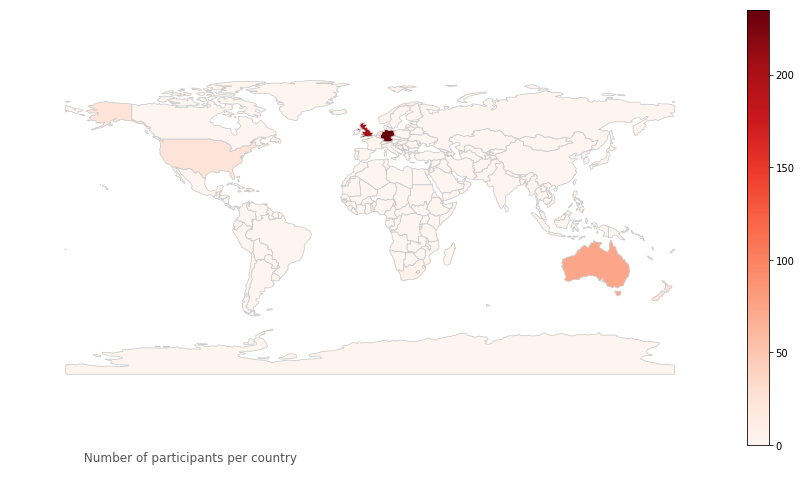

In [15]:
fig, ax = plt.subplots(1)
ax = df_map.plot(ax=ax, column='count', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)

# Add the description
description = """ Number of participants per country"""
plot = ax.annotate(description, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Remove axis
plot = ax.axis('off')

plt.show()

### Create a category world

As said, we are concerned about some countries specifically. However, we collect information about other countries as well. To avoid any confusion and having too much countries to plot, we group all of them into one category "world"

In [16]:
# Create a list of all countries of interest
list_countries = ['United Kingdom', 'Australia', 'United States', 'Germany', 'New Zealand', 'Netherlands', 'South Africa']

# Create a new columns if "World" if the country is not in the list
df['Country'] = df['socio1. In which country do you work?'].apply(lambda x: x if x in list_countries else 'World')

### Difference with the previous year

Several countries did the survey last year, here a summary of the difference in the amount of participants.

In [19]:
results = dict()
for country in df[df['Year']== 2017]['Country'].unique():
    current_year = df[df['Year']== 2018]['Country'].value_counts()[country]
    previous_year = df[df['Year']== 2017]['Country'].value_counts()[country]
    results[country] = {'2017': previous_year, '2018': current_year}
diff_year_participants = pd.DataFrame.from_dict(results, orient='index')
diff_year_participants['Difference between 2017 and 2018'] = diff_year_participants['2018'] - diff_year_participants['2017']

# Displaying the results
diff_year_participants

,2017,2018,Difference between 2017 and 2018
Germany,325,235,-90
Netherlands,77,28,-49
South Africa,22,5,-17
United Kingdom,253,208,-45
United States,164,24,-140


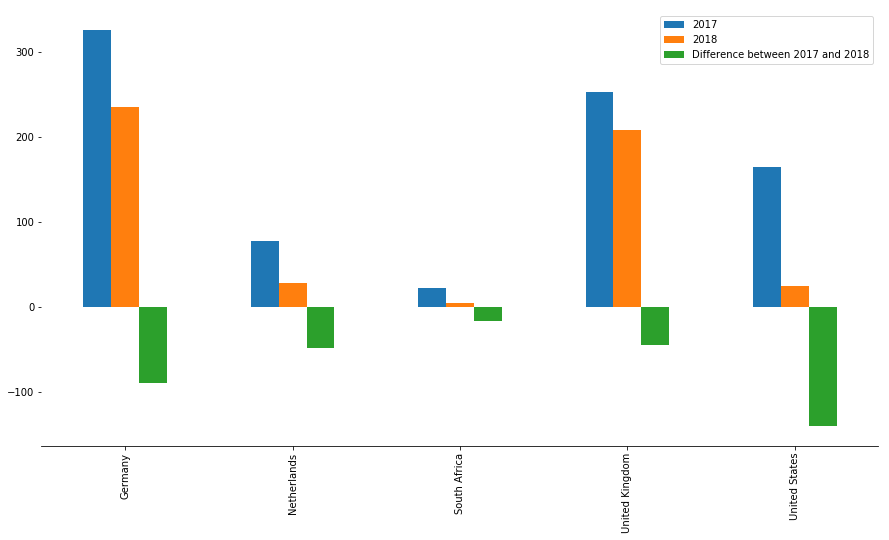

In [20]:
# Plotting the difference
ax = diff_year_participants.plot(kind='bar')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

plt.show()

## Selecting valid participants only

However, on this total of participants, we only want the participants that code software during their work. 
We had a specific question for this purpose. We asked the participants if they are writing software or if they are leading a group of software developers. Each of these questions had the possibility of Yes/No answer. Here the exact wording of the questions:

* Do you write software for academic research as part of your job
* Does the majority of your role comprise leading a group of software developers or RSEs?

We will only select the participants who answered `Yes` to at least one question.

In [21]:
# Get the count of Y/N for the software developers
soft_dev = df['rse1. Do you write software for academic research as part of your job'].value_counts().to_frame()

# Get the count of Y/N for the leader developers
soft_lead = df['rse4de. Does the majority of your role comprise leading a group of software developers or RSEs?'].value_counts().to_frame()

# Get the count for Y/N to any of the question
df['any_rse'] = np.where((df['rse1. Do you write software for academic research as part of your job'] == 'Yes') | (df['rse4de. Does the majority of your role comprise leading a group of software developers or RSEs?']), 'Yes', 'No')
soft_any = df['any_rse'].value_counts().to_frame()

# Create one df
result = pd.concat([soft_dev, soft_lead, soft_any], axis=1)#, sort=False)

# Rename columns
result.columns = ['Write software', 'Lead a team of software developers', 'At least one of the two']
result

,Write software,Lead a team of software developers,At least one of the two
No,51,652,14
Yes,1417,283,1454


This table is for both 2017 and 2018 year.For any further analysis, we remove the participants that answered 'No' at both of the question to only keep the ones that have work involving software development for both year to ensure a proper comparison. 

In [22]:
# Filtering the df
df = df[df['any_rse'] == 'Yes']
# drop the column `any_rse` as no use anymore
df.drop(['any_rse'], axis=1, inplace=True)

This brings the number of participants analysed to:

In [23]:
results = pd.DataFrame.from_dict([{'Participants in 2017': len(df[df['Year'] == 2017]), 
 'Participants in 2018': len(df[df['Year'] == 2018])}])
results

,Participants in 2017,Participants in 2018
0,828,626


## Education and previous formation

### Levels of education 

The education questions is tight to each countries as each of them have their own educative system. Therefore this section is separated between all countries.
All of them had the same question:
* What is the highest level of education you have attained?
But the list of diploma was different for each. 
If a participant answered from another country than the one listed at the beginning of the notebook, they could answer with a free text.

In [24]:
# Create a separated df for following sections
df_edu_per_country = df[df['Year'] == 2018][['Country', 'edu1. What is the highest level of education you have attained?']].copy()
df_edu_per_country.columns = ['Country', 'Education']

#### Australia

In [25]:
# Set up variables
country = 'Australia'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for Australia,,
AQF 10 - Doctoral Degree,45,61.64
AQF 8 - Bachelor Honours Degree / Graduate Certificate / Graduate Diploma,11,15.07
AQF 7 - Bachelor Degree,9,12.33
AQF 9 - Masters Degree,8,10.96


#### Germany

In [26]:
# Set up variables
country = 'Germany'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for Germany,,
Master degree,114,48.51
Doctorate,98,41.70
Undergraduate degree,15,6.38
"Final secondary-school examinations, general qualification for university entrance",6,2.55
Other,2,0.85


#### Netherlands

In [27]:
# Set up variables
country = 'Netherlands'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for Netherlands,,
PhD,13,46.43
WO (Wetenschappelijk onderwijs) Master,11,39.29
HBO (Hoger beroepsonderwijs) Master,2,7.14
HBO (Hoger beroepsonderwijs) Bachelor,1,3.57
WO (Wetenschappelijk onderwijs) Bachelor,1,3.57


#### New Zealand

In [28]:
# Set up variables
country = 'New Zealand'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for New Zealand,,
Doctorate,9,34.62
Master degree,7,26.92
Undergraduate degree,7,26.92
"Further Education (NVQ A-Level, ...)",2,7.69
Other,1,3.85


#### South Africa

In [29]:
# Set up variables
country = 'South Africa'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for South Africa,,
Master degree,2,40.0
"Further Education (NVQ A-Level, ...)",1,20.0
Other,1,20.0
Doctorate,1,20.0


#### United Kingdom

In [30]:
# Set up variables
country = 'United Kingdom'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for United Kingdom,,
Doctorate,144,69.57
Master degree,43,20.77
Undergraduate degree,19,9.18
GSCEs,1,0.48


#### United States

In [31]:
# Set up variables
country = 'United States'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for United States,,
Doctorate,12,50.00
Master degree,8,33.33
Undergraduate degree,3,12.50
Other,1,4.17


#### Rest of the World

In [36]:
# Set up variables
country = 'World'
index_name = 'Highest level of education for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_per_country[df_edu_per_country['Country'] == country]['Education'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Education'] / df_edu['Education'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Highest level of education for World,,
Doctorate,10,37.04
Ph.D.,2,7.41
masters,1,3.70
Dr. phil.,1,3.70
Phd,1,3.70
Masters degree,1,3.70
Masters,1,3.70
Master degree,1,3.70
Master in science,1,3.70


#### Comparison between countries

Even if the countries have different education levels, it is possible to match them on the common "Doctorate" and "Master degree". 
Therefore we compare them with these two equivalent levels and merge all others under the category "other".

In [37]:
# Create dictionary to replace values. These values may not be present in the current df but are present in the
# potential answers
dict_values = {'PhD': 'Doctorate', 
               'AQF 10 - Doctoral Degree': 'Doctorate',
               'HBO (Hoger beroepsonderwijs) Master': 'Master degree',
               'WO (Wetenschappelijk onderwijs) Master': 'Master degree',
               'AQF 9 - Masters Degree': 'Master degree'}
list_value_to_keep = ['Doctorate', 'Master degree', np.NaN]

# Replace the value in education
df_edu_per_country['Education'] = df_edu_per_country['Education'].replace(dict_values)

# Create a new columns if "World" if the country is not in the list
def merge_edu(x):
    if x in list_value_to_keep:
        return x
    elif x == np.NaN:
        return x
    else:
        return 'Other'
    
# Apply the function to a new columns
df_edu_per_country['Level of education'] = df_edu_per_country['Education'].apply(merge_edu)

# Count the values per countries
df_edu_comparison = df_edu_per_country.groupby('Country')['Level of education'].value_counts().rename('Total count').reset_index()

# Add a percentage of each type of diploma per countries
df_edu_comparison['Percentage per countries'] = (df_edu_comparison['Total count'] / df_edu_comparison.groupby('Country')['Total count'].transform('sum')*100).round(2)

# Display the results
df_edu_comparison

,Country,Level of education,Total count,Percentage per countries
0,Australia,Doctorate,45,61.64
1,Australia,Other,20,27.40
2,Australia,Master degree,8,10.96
3,Germany,Master degree,114,48.51
4,Germany,Doctorate,98,41.70
5,Germany,Other,23,9.79
6,Netherlands,Doctorate,13,46.43
7,Netherlands,Master degree,13,46.43
8,Netherlands,Other,2,7.14
9,New Zealand,Other,10,38.46


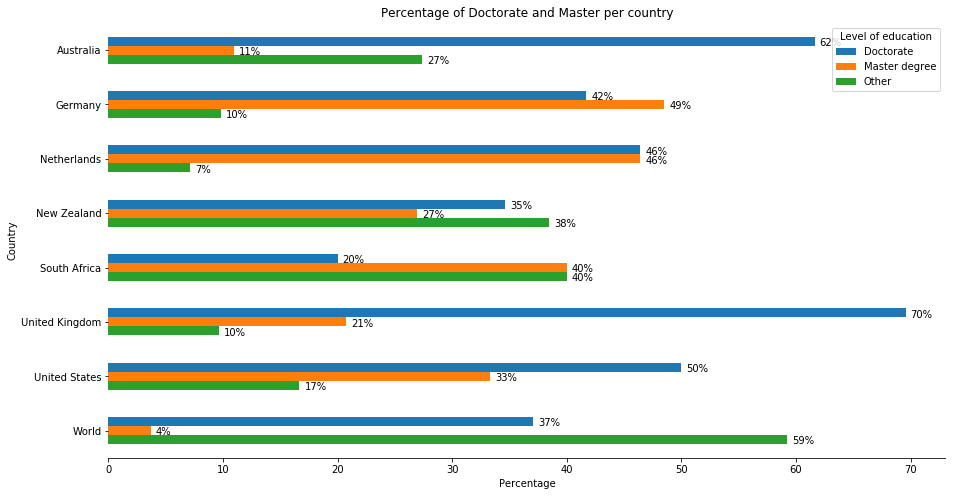

In [38]:
fig, ax = plt.subplots()
df_plot = df_edu_comparison.pivot(index='Country', 
                        columns='Level of education', 
                        values='Percentage per countries')
df_plot.plot(kind='barh',
                  title='Percentage of Doctorate and Master per country',
                  grid=False, ax=ax)

ax.set(xlabel="Percentage", ylabel="Country")

ax.invert_yaxis()  # when barh option, the bars are inverted 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 
for p in ax.patches:
    if int(round(p.get_width())) > 0:
        ax.annotate('{}%'.format(str(int(round(p.get_width())))), 
                                 (p.get_x() + p.get_width(), p.get_y()), 
                                  xytext=(5, -9),
                                  textcoords='offset points')
plt.show();

### Academic field for education

Alongside of question about education level we also asked the participants in which field they finished their highest level of education. 
Here again the propositions were specific to each countries.

In [ ]:
df['edu2. In which discipline is your highest academic qualification?']

In [40]:
# Create a column that merge all education columns
df['Academic field'] = df[df['Year'] == 2018]['edu2. In which discipline is your highest academic qualification?']

# There are numbers in some of the fields, removing them as they are not needed
def remove_digit(s):
    try:
        return ''.join([i for i in s if not i.isdigit()])
    except TypeError:
        return s

df['Academic field'] = df['Academic field'].apply(remove_digit)

# Create a separated df for following sections
df_edu_aca_per_country = df[['Country', 'Academic field']].copy()

#### Australia

In [41]:
# Set up variables
country = 'Australia'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for Australia,,
Physical Sciences,16,22.22
Information and Computing Sciences,15,20.83
Biological Sciences,13,18.06
Engineering,8,11.11
Earth Sciences,7,9.72
Mathematical Sciences,6,8.33
Environmental Sciences,1,1.39
Studies in Creative Arts and Writing,1,1.39
Chemical Sciences,1,1.39


#### Germany

In [42]:
# Set up variables
country = 'Germany'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for Germany,,
Computer Science,63,26.92
Physics and Astronomy,56,23.93
Geography & Environmental Sciences,17,7.26
Mathematics,16,6.84
Biological Sciences,15,6.41
Electrical & Electronic Engineering,12,5.13
Mechanical Engineering,6,2.56
Materials Technology,5,2.14
Chemical Engineering,5,2.14


#### Netherlands

In [43]:
# Set up variables
country = 'Netherlands'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for Netherlands,,
Biological Sciences,7,25.00
Physics and Astronomy,6,21.43
Computer Science,6,21.43
Politics,1,3.57
Communication & Media Studies,1,3.57
Chemistry,1,3.57
Electrical & Electronic Engineering,1,3.57
Civil Engineering,1,3.57
Chemical Engineering,1,3.57


#### New Zealand

In [44]:
# Set up variables
country = 'New Zealand'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for New Zealand,,
Computer Science,5,19.23
Biological Sciences,5,19.23
Mathematics,4,15.38
Physics and Astronomy,3,11.54
Mechanical Engineering,2,7.69
Business & Management Studies,2,7.69
Electrical & Electronic Engineering,2,7.69
Chemical Engineering,1,3.85
Geography & Environmental Sciences,1,3.85


#### South Africa

In [45]:
# Set up variables
country = 'South Africa'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for South Africa,,
Computer Science,2,50.0
Economics,1,25.0
Physics and Astronomy,1,25.0


#### United Kingdom

In [46]:
# Set up variables
country = 'United Kingdom'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for United Kingdom,,
Physics and Astronomy,68,33.01
Computer Science,52,25.24
Biological Sciences,22,10.68
Mathematics,15,7.28
Chemistry,12,5.83
Geography & Environmental Sciences,10,4.85
Electrical & Electronic Engineering,6,2.91
General Engineering,4,1.94
Geology,4,1.94


#### United States

In [47]:
# Set up variables
country = 'United States'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for United States,,
Biological Sciences,6,25.00
Physics and Astronomy,3,12.50
Computer Science,3,12.50
Mathematics,3,12.50
Music,2,8.33
East & South Asian Studies,1,4.17
Politics,1,4.17
History,1,4.17
Education,1,4.17


#### Rest of the world

In [48]:
# Set up variables
country = 'World'
index_name = 'Academic field for {}'.format(country)

# Get the count for edu1
df_edu = df_edu_aca_per_country [df_edu_aca_per_country['Country'] == country]['Academic field'].value_counts().to_frame()

# Add the percentage to the newly created df
df_edu['Percentage'] = (df_edu['Academic field'] / df_edu['Academic field'].sum()*100).round(2)

# Rename columns
df_edu.columns = ['Total count', 'Percentage']

# Change name of index 
df_edu.index.name = index_name

# Display the df
df_edu

,Total count,Percentage
Academic field for World,,
Physics and Astronomy,7,25.93
Biological Sciences,6,22.22
Computer Science,3,11.11
Geography & Environmental Sciences,2,7.41
Mathematics,2,7.41
Librarianship & Information Management,1,3.70
Education,1,3.70
Business & Management Studies,1,3.70
Psychology,1,3.70


#### Comparison between countries

In [49]:
# Count the values per countries
df_edu_comparison = df_edu_aca_per_country.groupby('Country')['Academic field'].value_counts().rename('Total count').reset_index()

# Add a percentage of each type of diploma per countries
df_edu_comparison['Percentage per countries'] = (df_edu_comparison['Total count'] / df_edu_comparison.groupby('Country')['Total count'].transform('sum')*100).round(2)

# Display the results
df_edu_comparison

,Country,Academic field,Total count,Percentage per countries
0,Australia,Physical Sciences,16,22.22
1,Australia,Information and Computing Sciences,15,20.83
2,Australia,Biological Sciences,13,18.06
3,Australia,Engineering,8,11.11
4,Australia,Earth Sciences,7,9.72
5,Australia,Mathematical Sciences,6,8.33
6,Australia,Chemical Sciences,1,1.39
7,Australia,Environmental Sciences,1,1.39
8,Australia,Medical and Health Sciences,1,1.39
9,Australia,Philosophy and Religious Studies,1,1.39


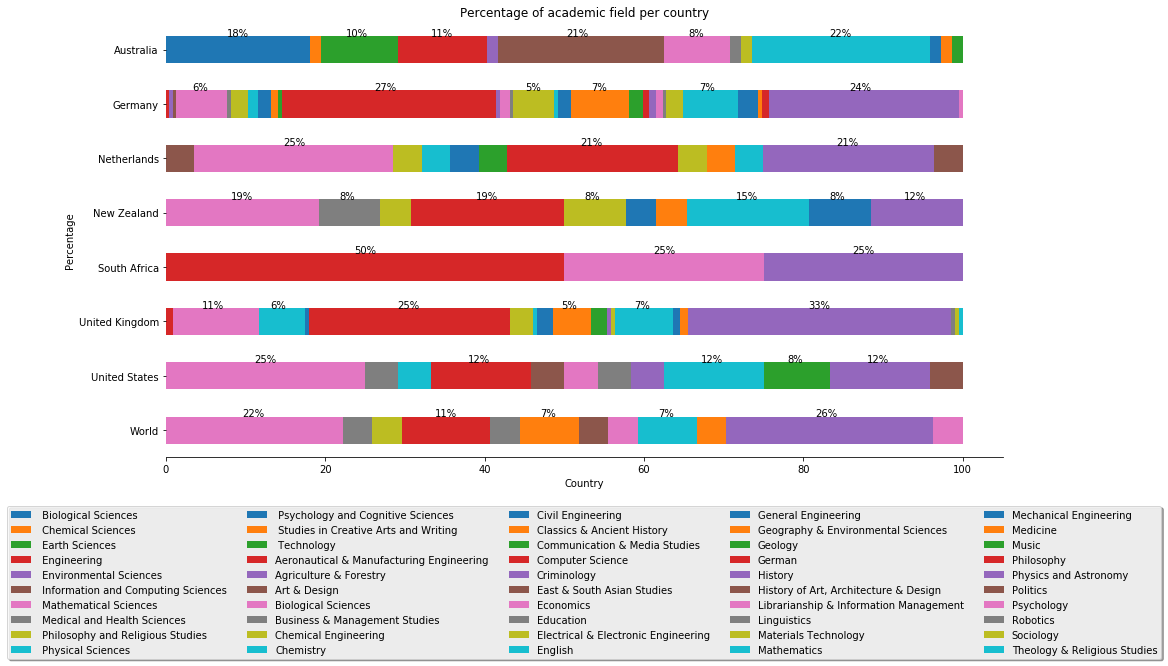

In [50]:
fig, ax = plt.subplots()
df_plot = df_edu_comparison.pivot(index='Country', 
                        columns='Academic field', 
                        values='Percentage per countries')

df_plot.plot(kind='barh',
                  title='Percentage of academic field per country',
                  grid=False, ax=ax, stacked=True)

ax.set(xlabel="Country", ylabel="Percentage")

ax.invert_yaxis()  # when barh option, the bars are inverted 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
for p in ax.patches:
    if int(round(p.get_width())) >= 5:
        ax.annotate('{}%'.format(str(int(round(p.get_width())))), 
                    (p.get_x() + int(p.get_width())/2., p.get_y()+ int(p.get_height())/2.),
                    ha='center')

plt.show();